In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data.txt','\t')

In [3]:
normalized_data = data.copy()
# normalize X
high = data['X'].max()
low = data['X'].min()
normalized_data['X'] = ((data['X'] - low) / (high - low)) * 10 # within [-0.1,0.1]

# normalize Y
high = data['Y'].max()
low = data['Y'].min()
normalized_data['Y'] = ((data['Y'] - low) / (high - low)) * 10 # within [-0.1,0.1]

# timestamp / 40
normalized_data['timestamp'] = (data['timestamp'] / 40).map(int)

In [4]:
normalized_data.to_csv('data_normalized.csv')

In [10]:
# functions for generate a batch of sample
'''
    Input:
        data: the CSV
        num_data: size of batch
    Output:
        IDs: list of selected IDs
        input_sequence: batch with shape (num_data,input_length, 2)
        output_sequence: batch with shape (num_data, output_length, 2)
'''
from random import shuffle
def get_batch(data,num_data = 128,input_length = 8, output_length = 4):
    # evaluate the total length of series required
    total_length = input_length + output_length
    # filter out the series that has at least the number of `total_length` long
    id_counts = data.groupby('ID').ID.count()
    # get a table of candidate id, whose sequence is longer than (or eq. to) total_length
    candidate_id_counts = id_counts[id_counts >= total_length]
    # get the random sequence...
    # the candidate_id_counts is a series with ID as x and count as y
    # to get the usable indices, get list series as a list of tuple like (id, count),
    # then take the first one (list of id)
    # and make it a list, and shuffle on it
    random_ids_selected = list(map(lambda tup: tup[0],candidate_id_counts.items()))
    shuffle(random_ids_selected)
    
    selected_ids = []
    input_batch = []
    target_batch = []
    # retrieve the coordinates of the sequence (from the beginning to `total_length`)
    for i in random_ids_selected[:num_data]:
        selected_ids.append(i)
        # select X,Y from ID where ID == i order by timestamp...
        sequence_of_i = data[data.ID == i].sort_values(by = "timestamp")[["X","Y"]]
        # divide the sequence into two parts...
        input_sequence = sequence_of_i.iloc[:input_length]
        target_sequence = sequence_of_i.iloc[input_length:total_length]
        # and append the new sequence to existing arrays
        input_batch.append(np.array(input_sequence))
        target_batch.append(np.array(target_sequence))
    
    # return and array of selected ids as well as the batch...
    return np.stack(selected_ids), np.stack(input_batch), np.stack(target_batch)
    

# verify the shape is right...
list(map(lambda a: a.shape,get_batch(normalized_data)))
    

[(128,), (128, 8, 2), (128, 4, 2)]

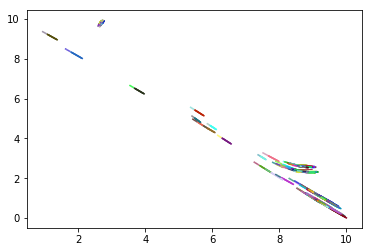

In [11]:
'''
    Visualize the traces in a batch
    If batch size = B, sequence length = L...
    Input:
        batch: batch of sequence of arbitrary length, i.e. array of shape (B,L,2)
    Output:
        None, a graph will be drawn instead..
'''

import matplotlib.pyplot as plt
def visualize_trace(batch,target_batch):
    # first we make sure that the shape of the batch looks like (_, _, 2)
    def check_shape(shape):
        if len(shape) != 3:
            raise ValueError("batch should be in 3 dimension")
        if shape[-1] != 2:
            raise ValueError("Last axis should be storing X,Y coordinates")
    
    check_shape(batch.shape)
    check_shape(target_batch.shape)
    # sub-routine for draw a particular batch
    def draw_batch(batch,linestyle = None):
        # now extract the dimension
        batch_size, sequence_length, _ = batch.shape
        for batch_id in range(batch_size):
            # pick a random color for this trace
            line_color = np.random.rand(3)
            for sequence_pos in range(sequence_length - 1):
                # get the two adjacent coordinates
                cur_coord = batch[batch_id, sequence_pos]
                next_coord = batch[batch_id, sequence_pos + 1]
                # and draw the line...
                # sneaky plot function requires x-coordinates to be put in the same argument, so are y-coordinates...
                plt.plot([cur_coord[0],next_coord[0]],
                         [cur_coord[1],next_coord[1]],
                         linestyle = linestyle,
                         c = line_color)
    
    draw_batch(batch)
    draw_batch(target_batch, ":")
    # finally show the graph
#     plt.show()
    
# let's test this visualization,
_, input_batch, target_batch = get_batch(normalized_data,128,16,8)
visualize_trace(input_batch,target_batch)

In [12]:
# now lets define a vanilla LSTM model
'''
    According to the paper, there should be an RNN that takes a sequence and gives a sequence (like seq-to-seq)
    except this output are hidden layers, like vectors of length 128
    To interpret such result, a dense layer with ReLU is added to condense the output to 5 numbers,
    namely, the mean_x, mean_y, sxx, syy, and sxy 
    of the bivariate gaussian of the probability of the agent at that given timestamp.
    
    The negative log likelihood between the real coordinate and this estimated distribution will be the loss.
'''
# first, the loss function, in Keras backend
from keras.layers import *
import keras.backend as K
'''
    The function takes a series of params of bivariate normal distribution, and a batch of observed coordinates,
    and return the log likelikhood of them...
    
    probability (likelihood) of the observed point (x,y) given the 5 parameters (mx,my,sx,sy,sp):
        det(2 * pi * [[sx,sp],[sp,sy]]) ^(-0.5) 
            * exp(-0.5 * ((x,y) - (mx,my)).T * [[sx,sp],[sp,sy]] * ((x,y) - (mx,my)))
    
    after taking log and add a minus (* -1)...
        -( (-0.5 * log(4 * pi ^ 2 * sx * sy - sp * sp)) + (-0.5 * (...)))
    
    If batch size = B, sequence length = D...
    Input:
        Batch bivariate parameters (estimated): K.variable with shape (B,D,5),
        Batch of overserved coordinates (label): K.variable with shape (B,D,2)
    
    Output:
        a scaler (K.variable with shape ()), which is the sum of negative log likelihood
'''

def negative_log_likelihood_loss(batch_observed_coordinates,batch_bivariate_params):
    # first check the dimension...
    input_shape = K.int_shape(batch_bivariate_params)
    target_shape = K.int_shape(batch_observed_coordinates)
    
    if len(input_shape) != 3 or len(target_shape) != 3:
        raise ValueError("Dimension of both tensors should be 3")
    
    if input_shape[0] != target_shape[0]:
        raise ValueError("Batch size of both tensors should be the same")
    
    if input_shape[1] != target_shape[1]:
        raise ValueError("Sequence length of both tensors should be the same")
    
    if input_shape[2] != 5:
        raise ValueError("Number of predicted parameters should be 5. Namely, (mx,my,sx,sy,sp)")
    
    if target_shape[2] != 2:
        raise ValueError("Dimension of target coordinates should be 2. Namely, (x,y)")
    
    # then split the tensors into (mx,my,sx,sy,sp)...
    # all of them should be of shape (B,D)
    batch_mx = batch_bivariate_params[:,:,0]
    batch_my = batch_bivariate_params[:,:,1]
    batch_sx = batch_bivariate_params[:,:,2]
    batch_sy = batch_bivariate_params[:,:,3]
    batch_sp = batch_bivariate_params[:,:,4]
    
    batch_x = batch_observed_coordinates[:,:,0]
    batch_y = batch_observed_coordinates[:,:,1]
    
    dx = batch_x - batch_mx # (B,D), (x - mx)
    dy = batch_y - batch_my # (B,D), (y - my)
    dydx = Multiply()([dx,dy])
    
    batch_x_change =  K.concatenate([batch_mx[:,0:1], batch_mx[:,1:] - batch_mx[:,:-1]])
    batch_y_change =  K.concatenate([batch_my[:,0:1], batch_my[:,1:] - batch_my[:,:-1]])
    target_x_change =  K.concatenate([batch_x[:,0:1], batch_x[:,1:] - batch_x[:,:-1]])
    target_y_change =  K.concatenate([batch_y[:,0:1], batch_y[:,1:] - batch_y[:,:-1]])
    
    xy_dot = Multiply()([batch_x_change,target_x_change]) + Multiply()([batch_y_change,target_y_change])
    batch_change_norm = K.sqrt(K.square(batch_x_change) + K.square(batch_y_change))
    target_change_norm = K.sqrt(K.square(target_x_change) + K.square(target_y_change))
    
    norm_prod = Multiply()([batch_change_norm,target_change_norm]) + 1e-6
    norm_prod_inv = K.pow(norm_prod,-1) # for numerical stability
    direction_loss =  - K.mean(Multiply()([xy_dot,norm_prod_inv]))
#     det_inv = K.print_tensor(K.pow(det,-1), message="det_inv") # (B,D), (sx * sy - sp^2) ^-1
    # (B,D), (dx^2 * sy - 2 * sp * dy * dx + sx * dy^2)
    exp = -0.5 * Multiply()([K.square(dx),batch_sy]) - 2 * Multiply()([dydx, batch_sp]) + Multiply()([K.square(dy),batch_sx])
    # (B,D), -0.5 * (dx^2 * sy - 2 * sp * dy * dx + sx * dy^2) * det(Cov)^(-1)
#     exp = Multiply()([det_inv,exp]) * (-0.5)
    
    # evaluate the final NLL
    '''
        A remark here: it is determined that the determininat of the covariance matrix will not be considered as a loss,
        as the value of that generally became very large (under the log function)
        therefore only the exponents are used as the loss
    '''
#     batch_nll = - (exp)
    batch_nll = K.square(dx) + K.square(dy) - 0.1 * exp + 0.1 * direction_loss
    batch_error_total = K.sum(batch_nll, axis = 1) # (B,) sum of NLL in a sequence...
    return K.print_tensor(K.mean(batch_error_total, axis = 0)) # (), average of sum of NLL...

# now test it...
# a regular 0-centered, non-skewing normal
[mx,my,sx,sy,sp] = [0,0,.1,.1,0.]
bivariate_params = np.array([[[mx,my,sx,sy,sp]]]) # (1,1,5)
target_point = np.array([[[-0.,0]]]) # (1,1,2)

bivariate_ph = K.variable(value = bivariate_params, dtype = "float32")
target_ph = K.variable(value = target_point, dtype = "float32")
nll = negative_log_likelihood_loss(target_ph,bivariate_ph)
K.eval(nll)

0.0

In [13]:
def infer_layer(batch_predicted_coordinates):
    return K.cumsum(batch_predicted_coordinates,axis = 1)
    
def check_tensor(batch_observed_coordinates,batch_predicted_coordinates):
    input_shape = K.int_shape(batch_predicted_coordinates)
    target_shape = K.int_shape(batch_observed_coordinates)

    if len(input_shape) != 3 or len(target_shape) != 3:
        raise ValueError("Dimension of both tensors should be 3")

    if input_shape[0] != target_shape[0]:
        raise ValueError("Batch size of both tensors should be the same")

    if input_shape[1] != target_shape[1]:
        raise ValueError("Sequence length of both tensors should be the same")

    if input_shape[2] != 2:
        raise ValueError("Number of predicted parameters should be 2. Namely, (mx,my)")

    if target_shape[2] != 2:
        raise ValueError("Dimension of target coordinates should be 2. Namely, (x,y)")
    
def ms_loss(input_tensor):
    batch_observed_coordinates,batch_predicted_coordinates = input_tensor
    # first check the dimension...
    check_tensor(batch_observed_coordinates,batch_predicted_coordinates)
    
    diff = K.square(batch_predicted_coordinates - batch_observed_coordinates)

    return K.sum(diff)

def dir_loss(input_tensor):
    batch_observed_coordinates,batch_predicted_coordinates = input_tensor
    check_tensor(batch_observed_coordinates,batch_predicted_coordinates)
    
    predict_dir = batch_predicted_coordinates[:,1:] - batch_predicted_coordinates[:,:-1]
    
    target_dir = batch_observed_coordinates[:,1:] - batch_observed_coordinates[:,:-1]
    
#     predic_dir_norm = 
    # this is to maximize the cosine (therefore angle = 0)
    return K.sum(K.square((predict_dir - target_dir)))

In [14]:
# then, the Vanilla LSTM
from keras.models import Model
from keras.initializers import RandomNormal
from keras import optimizers
def vanilla_lstm_model(num_hidden, input_length, predict_length, lr = 1e-3):
# def vanilla_lstm_model(num_hidden,input_length, predict_length, input_tensor, target_tensor):
    total_length = input_length + predict_length
    # the input
    input_sequence = Input(shape = (total_length,2), name = 'input_sequence', dtype = 'float32') # (T, 2)
    target_sequence = Input(shape = (total_length,2), name = 'target_sequence', dtype = 'float32') # (T, 2)
    lstm = LSTM(num_hidden, return_sequences = True)(input_sequence) # (B,T,num_hidden)
#     params = TimeDistributed(Dense(5, activation = 'elu'), name = 'params')(lstm) # (B,T,5)
    predicted_coordinates_raw = TimeDistributed(Dense(2, activation = 'elu'), name = 'params')(lstm)
    
    # retrieve the prediction
    extract_target_sequence_layer = Lambda(lambda x: x[:,input_length:,:])
    predicted_coordinates_masked = extract_target_sequence_layer(predicted_coordinates_raw)
    target_coordinates_masked = extract_target_sequence_layer(target_sequence)
    # the output layer
    predicted_output = Lambda(infer_layer, name = "predict")(predicted_coordinates_masked)
    # compute the loss
    
    # first part: the square loss
    sq_loss = Lambda(ms_loss, name = 'square_loss')([target_coordinates_masked, predicted_output])
    # second part: the direction loss
    ori_loss = Lambda(dir_loss, name = 'dir_loss')([target_coordinates_masked, predicted_output])
    
    loss = Lambda(lambda ts: ts[0] + ts[1],name = 'loss')([sq_loss, ori_loss])
    
    model = Model(
        inputs = [input_sequence,target_sequence],
        outputs = [predicted_output,loss])
    
    model.compile(optimizer=optimizers.RMSprop(lr = lr, clipvalue = 10., decay = 1e-6),
                  # since there are two outputs of the model, the estimated params and the NLL,
                  # their loss value should be specified.
                  # for params there are no loss regarding its value, but I just assign a zero as loss (or the computational graph will break)
                  # I made it loss - loss = 0.
                  # and for the NLL, return the loss as-is.
                  loss= {
                        'predict': lambda _, loss: loss - loss, # meh...
                          'loss': lambda _, loss: loss
                    })
    
    return input_sequence, target_sequence, model, predicted_output,loss




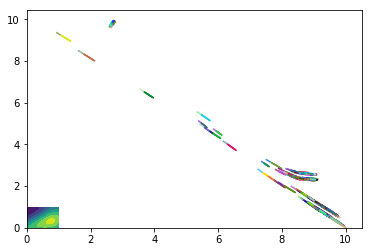

In [15]:
# helper function for monitoring training progress
from scipy.stats import multivariate_normal
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
'''
    Given a set of parameter (array of 5), visualize the heatmap of the bivariate normal distribution
'''
def draw_heatmap(params):
    resolution = 100
    interval = 1. / resolution
    
    x,y = np.mgrid[0:1:interval,0:1:interval]
    pos = np.empty(x.shape + (2,))
    pos[:,:,0] = x
    pos[:,:,1] = y
    result_distribution = None
    for param in params:
        mx,my,sx,sy,sp = param
        F = multivariate_normal([mx,my],[[sx,sp],[sp,sy]])
        result_distribution = F.pdf(pos) if result_distribution is None else result_distribution + F.pdf(pos)
    plt.contourf(x,y,result_distribution)

# try it out
# fig = plt.figure()
draw_heatmap(np.array([[0.3,0.1,0.4,0.2,.2],[0.9,0.2,0.1,0.9,0.]]))
visualize_trace(input_batch,target_batch)
# draw_heatmap(0.3,0.2,0.01,0.2,0.,fig)
plt.show()

'''
    Draw the mean of the predicted params of all timestamps
'''
import matplotlib.cm as cm
def draw_mean(params):
    plt.xlim(0,10)
    plt.ylim(0,10)
    
    
    for batch in range(params.shape[0]):
        line_color = np.random.rand(3) # choose a color to tell that these scatter points belong to the same prediction
        xy_series = params[batch,:,:] # (D,2)
        # prgressively change the color to indicate the direction
        colors = cm.rainbow(np.linspace(0, 1, params.shape[1]))
        plt.scatter(xy_series[:,0],xy_series[:,1], c = colors)

In [27]:
from keras.callbacks import ReduceLROnPlateau, CSVLogger, LambdaCallback
from livelossplot import PlotLossesKeras # kudos :)
def get_callbacks(input_batch_padded,target_batch_padded,finetune = False):
    # prepare callbacks
    reduce_lr = ReduceLROnPlateau(monitor='loss', 
                                  factor=0.5,
                                  patience=50, 
                                  min_lr=1e-6)
    csv_logger = CSVLogger("log.csv")

    def visualize_prediction(epoch, logs):
        params, loss = model.predict([input_batch_padded,target_batch_padded])
        # visualize the trace, as well as the distributions generated by the params...
        # first clear the previous drawing...
    #     try:
        plt.gcf().clear()
        visualize_trace(input_batch,target_batch)
    #     params = params[:,INPUT_LENGTH + 1, :] # (B,5), and it should be the params immediately after the input
    #     draw_heatmap(params)
        draw_mean(params)
        filename = '{}.png' if not finetune else '{}-finetune.png'
        plt.savefig(filename.format(epoch))

    plot_callback = LambdaCallback(on_epoch_begin = visualize_prediction)
    
    return [reduce_lr, 
            csv_logger,
            #PlotLossesKeras(),
           # plot_callback
           ]

In [31]:
# now run the training!
INPUT_LENGTH = 8
OUTPUT_LENGTH = 4
TOTAL_LENGTH = INPUT_LENGTH + OUTPUT_LENGTH
BATCH_SIZE = 256

inp_ph,target_ph, model, params, loss = vanilla_lstm_model(128,
                                                           INPUT_LENGTH,
                                                           OUTPUT_LENGTH,
                                                          1e-3)
model.summary()
indices, input_batch, target_batch = get_batch(normalized_data,BATCH_SIZE,INPUT_LENGTH,OUTPUT_LENGTH)

# prepare data
input_batch_padded = np.hstack([input_batch,np.zeros((BATCH_SIZE,OUTPUT_LENGTH,2))])
target_batch_padded = np.hstack([np.zeros((BATCH_SIZE,INPUT_LENGTH,2)),target_batch])


# and train
model.fit(
    [input_batch_padded,target_batch_padded],
    [np.zeros((BATCH_SIZE,TOTAL_LENGTH,2)),np.zeros(BATCH_SIZE)],
    epochs = 1500,
    validation_split = 0.2,
    callbacks = get_callbacks(input_batch_padded,target_batch_padded)
)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_sequence (InputLayer)     (None, 12, 2)        0                                            
__________________________________________________________________________________________________
lstm_9 (LSTM)                   (None, 12, 128)      67072       input_sequence[0][0]             
__________________________________________________________________________________________________
params (TimeDistributed)        (None, 12, 2)        258         lstm_9[0][0]                     
__________________________________________________________________________________________________
lambda_9 (Lambda)               (None, 4, 2)         0           params[0][0]                     
                                                                 target_sequence[0][0]            
__________

204/204 [==============================] - 0s 600us/step - loss: 191.1354 - predict_loss: 0.0000e+00 - loss_loss: 191.1354 - val_loss: 61.7069 - val_predict_loss: 0.0000e+00 - val_loss_loss: 61.7069
Epoch 27/1500
204/204 [==============================] - 0s 526us/step - loss: 179.6224 - predict_loss: 0.0000e+00 - loss_loss: 179.6224 - val_loss: 84.7678 - val_predict_loss: 0.0000e+00 - val_loss_loss: 84.7678
Epoch 28/1500
204/204 [==============================] - 0s 566us/step - loss: 165.3809 - predict_loss: 0.0000e+00 - loss_loss: 165.3809 - val_loss: 59.2098 - val_predict_loss: 0.0000e+00 - val_loss_loss: 59.2098
Epoch 29/1500
204/204 [==============================] - 0s 529us/step - loss: 175.5767 - predict_loss: 0.0000e+00 - loss_loss: 175.5767 - val_loss: 53.2334 - val_predict_loss: 0.0000e+00 - val_loss_loss: 53.2334
Epoch 30/1500
204/204 [==============================] - 0s 567us/step - loss: 150.5504 - predict_loss: 0.0000e+00 - loss_loss: 150.5504 - val_loss: 35.4156 - val

Epoch 65/1500
204/204 [==============================] - 0s 464us/step - loss: 33.3623 - predict_loss: 0.0000e+00 - loss_loss: 33.3623 - val_loss: 5.3945 - val_predict_loss: 0.0000e+00 - val_loss_loss: 5.3945
Epoch 66/1500
204/204 [==============================] - 0s 416us/step - loss: 41.5813 - predict_loss: 0.0000e+00 - loss_loss: 41.5813 - val_loss: 4.8726 - val_predict_loss: 0.0000e+00 - val_loss_loss: 4.8726
Epoch 67/1500
204/204 [==============================] - 0s 428us/step - loss: 38.0115 - predict_loss: 0.0000e+00 - loss_loss: 38.0115 - val_loss: 11.6048 - val_predict_loss: 0.0000e+00 - val_loss_loss: 11.6048
Epoch 68/1500
204/204 [==============================] - 0s 456us/step - loss: 35.2191 - predict_loss: 0.0000e+00 - loss_loss: 35.2191 - val_loss: 10.6899 - val_predict_loss: 0.0000e+00 - val_loss_loss: 10.6899
Epoch 69/1500
204/204 [==============================] - 0s 358us/step - loss: 40.0179 - predict_loss: 0.0000e+00 - loss_loss: 40.0179 - val_loss: 2.4745 - val_

204/204 [==============================] - 0s 505us/step - loss: 19.7546 - predict_loss: 0.0000e+00 - loss_loss: 19.7546 - val_loss: 2.1223 - val_predict_loss: 0.0000e+00 - val_loss_loss: 2.1223
Epoch 105/1500
204/204 [==============================] - 0s 489us/step - loss: 17.8111 - predict_loss: 0.0000e+00 - loss_loss: 17.8111 - val_loss: 2.6331 - val_predict_loss: 0.0000e+00 - val_loss_loss: 2.6331
Epoch 106/1500
204/204 [==============================] - 0s 487us/step - loss: 19.4926 - predict_loss: 0.0000e+00 - loss_loss: 19.4926 - val_loss: 3.1627 - val_predict_loss: 0.0000e+00 - val_loss_loss: 3.1627
Epoch 107/1500
204/204 [==============================] - 0s 482us/step - loss: 20.0808 - predict_loss: 0.0000e+00 - loss_loss: 20.0808 - val_loss: 4.1975 - val_predict_loss: 0.0000e+00 - val_loss_loss: 4.1975
Epoch 108/1500
204/204 [==============================] - 0s 506us/step - loss: 16.3925 - predict_loss: 0.0000e+00 - loss_loss: 16.3925 - val_loss: 2.1063 - val_predict_loss: 

204/204 [==============================] - 0s 492us/step - loss: 17.0299 - predict_loss: 0.0000e+00 - loss_loss: 17.0299 - val_loss: 2.3977 - val_predict_loss: 0.0000e+00 - val_loss_loss: 2.3977
Epoch 144/1500
204/204 [==============================] - 0s 532us/step - loss: 15.1442 - predict_loss: 0.0000e+00 - loss_loss: 15.1442 - val_loss: 2.9286 - val_predict_loss: 0.0000e+00 - val_loss_loss: 2.9286
Epoch 145/1500
204/204 [==============================] - 0s 522us/step - loss: 10.3825 - predict_loss: 0.0000e+00 - loss_loss: 10.3825 - val_loss: 1.8344 - val_predict_loss: 0.0000e+00 - val_loss_loss: 1.8344
Epoch 146/1500
204/204 [==============================] - 0s 501us/step - loss: 17.1699 - predict_loss: 0.0000e+00 - loss_loss: 17.1699 - val_loss: 1.7480 - val_predict_loss: 0.0000e+00 - val_loss_loss: 1.7480
Epoch 147/1500
204/204 [==============================] - 0s 487us/step - loss: 14.4832 - predict_loss: 0.0000e+00 - loss_loss: 14.4832 - val_loss: 1.9192 - val_predict_loss: 

204/204 [==============================] - 0s 484us/step - loss: 8.0382 - predict_loss: 0.0000e+00 - loss_loss: 8.0382 - val_loss: 3.7790 - val_predict_loss: 0.0000e+00 - val_loss_loss: 3.7790
Epoch 183/1500
204/204 [==============================] - 0s 438us/step - loss: 8.9320 - predict_loss: 0.0000e+00 - loss_loss: 8.9320 - val_loss: 1.9538 - val_predict_loss: 0.0000e+00 - val_loss_loss: 1.9538
Epoch 184/1500
204/204 [==============================] - 0s 462us/step - loss: 14.3683 - predict_loss: 0.0000e+00 - loss_loss: 14.3683 - val_loss: 1.8224 - val_predict_loss: 0.0000e+00 - val_loss_loss: 1.8224
Epoch 185/1500
204/204 [==============================] - 0s 467us/step - loss: 7.0325 - predict_loss: 0.0000e+00 - loss_loss: 7.0325 - val_loss: 5.4312 - val_predict_loss: 0.0000e+00 - val_loss_loss: 5.4312
Epoch 186/1500
204/204 [==============================] - 0s 454us/step - loss: 11.5956 - predict_loss: 0.0000e+00 - loss_loss: 11.5956 - val_loss: 2.4613 - val_predict_loss: 0.0000

204/204 [==============================] - 0s 501us/step - loss: 9.7561 - predict_loss: 0.0000e+00 - loss_loss: 9.7561 - val_loss: 2.1299 - val_predict_loss: 0.0000e+00 - val_loss_loss: 2.1299
Epoch 222/1500
204/204 [==============================] - 0s 462us/step - loss: 7.8118 - predict_loss: 0.0000e+00 - loss_loss: 7.8118 - val_loss: 1.3013 - val_predict_loss: 0.0000e+00 - val_loss_loss: 1.3013
Epoch 223/1500
204/204 [==============================] - 0s 489us/step - loss: 9.6890 - predict_loss: 0.0000e+00 - loss_loss: 9.6890 - val_loss: 1.2772 - val_predict_loss: 0.0000e+00 - val_loss_loss: 1.2772
Epoch 224/1500
204/204 [==============================] - 0s 499us/step - loss: 6.8595 - predict_loss: 0.0000e+00 - loss_loss: 6.8595 - val_loss: 1.5198 - val_predict_loss: 0.0000e+00 - val_loss_loss: 1.5198
Epoch 225/1500
204/204 [==============================] - 0s 496us/step - loss: 9.7780 - predict_loss: 0.0000e+00 - loss_loss: 9.7780 - val_loss: 1.6085 - val_predict_loss: 0.0000e+00

204/204 [==============================] - 0s 538us/step - loss: 9.7281 - predict_loss: 0.0000e+00 - loss_loss: 9.7281 - val_loss: 1.5838 - val_predict_loss: 0.0000e+00 - val_loss_loss: 1.5838
Epoch 261/1500
204/204 [==============================] - 0s 509us/step - loss: 8.5382 - predict_loss: 0.0000e+00 - loss_loss: 8.5382 - val_loss: 1.0577 - val_predict_loss: 0.0000e+00 - val_loss_loss: 1.0577
Epoch 262/1500
204/204 [==============================] - 0s 475us/step - loss: 5.6723 - predict_loss: 0.0000e+00 - loss_loss: 5.6723 - val_loss: 1.6261 - val_predict_loss: 0.0000e+00 - val_loss_loss: 1.6261
Epoch 263/1500
204/204 [==============================] - 0s 458us/step - loss: 9.6587 - predict_loss: 0.0000e+00 - loss_loss: 9.6587 - val_loss: 1.2780 - val_predict_loss: 0.0000e+00 - val_loss_loss: 1.2780
Epoch 264/1500
204/204 [==============================] - 0s 487us/step - loss: 5.8359 - predict_loss: 0.0000e+00 - loss_loss: 5.8359 - val_loss: 2.8828 - val_predict_loss: 0.0000e+00

204/204 [==============================] - 0s 502us/step - loss: 5.7714 - predict_loss: 0.0000e+00 - loss_loss: 5.7714 - val_loss: 0.7022 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.7022
Epoch 300/1500
204/204 [==============================] - 0s 472us/step - loss: 9.6308 - predict_loss: 0.0000e+00 - loss_loss: 9.6308 - val_loss: 1.4014 - val_predict_loss: 0.0000e+00 - val_loss_loss: 1.4014
Epoch 301/1500
204/204 [==============================] - 0s 430us/step - loss: 4.1852 - predict_loss: 0.0000e+00 - loss_loss: 4.1852 - val_loss: 0.9705 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.9705
Epoch 302/1500
204/204 [==============================] - 0s 466us/step - loss: 7.1185 - predict_loss: 0.0000e+00 - loss_loss: 7.1185 - val_loss: 2.3067 - val_predict_loss: 0.0000e+00 - val_loss_loss: 2.3067
Epoch 303/1500
204/204 [==============================] - 0s 485us/step - loss: 9.3076 - predict_loss: 0.0000e+00 - loss_loss: 9.3076 - val_loss: 2.1862 - val_predict_loss: 0.0000e+00

204/204 [==============================] - 0s 464us/step - loss: 4.4366 - predict_loss: 0.0000e+00 - loss_loss: 4.4366 - val_loss: 1.4155 - val_predict_loss: 0.0000e+00 - val_loss_loss: 1.4155
Epoch 339/1500
204/204 [==============================] - 0s 501us/step - loss: 6.9557 - predict_loss: 0.0000e+00 - loss_loss: 6.9557 - val_loss: 1.2829 - val_predict_loss: 0.0000e+00 - val_loss_loss: 1.2829
Epoch 340/1500
204/204 [==============================] - 0s 509us/step - loss: 5.5435 - predict_loss: 0.0000e+00 - loss_loss: 5.5435 - val_loss: 2.1514 - val_predict_loss: 0.0000e+00 - val_loss_loss: 2.1514
Epoch 341/1500
204/204 [==============================] - 0s 470us/step - loss: 7.2882 - predict_loss: 0.0000e+00 - loss_loss: 7.2882 - val_loss: 1.7839 - val_predict_loss: 0.0000e+00 - val_loss_loss: 1.7839
Epoch 342/1500
204/204 [==============================] - 0s 505us/step - loss: 5.6924 - predict_loss: 0.0000e+00 - loss_loss: 5.6924 - val_loss: 0.9075 - val_predict_loss: 0.0000e+00

204/204 [==============================] - 0s 524us/step - loss: 7.5963 - predict_loss: 0.0000e+00 - loss_loss: 7.5963 - val_loss: 1.3208 - val_predict_loss: 0.0000e+00 - val_loss_loss: 1.3208
Epoch 378/1500
204/204 [==============================] - 0s 404us/step - loss: 4.4030 - predict_loss: 0.0000e+00 - loss_loss: 4.4030 - val_loss: 1.8235 - val_predict_loss: 0.0000e+00 - val_loss_loss: 1.8235
Epoch 379/1500
204/204 [==============================] - 0s 470us/step - loss: 6.6208 - predict_loss: 0.0000e+00 - loss_loss: 6.6208 - val_loss: 1.5277 - val_predict_loss: 0.0000e+00 - val_loss_loss: 1.5277
Epoch 380/1500
204/204 [==============================] - 0s 519us/step - loss: 5.3980 - predict_loss: 0.0000e+00 - loss_loss: 5.3980 - val_loss: 0.9204 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.9204
Epoch 381/1500
204/204 [==============================] - 0s 498us/step - loss: 5.9485 - predict_loss: 0.0000e+00 - loss_loss: 5.9485 - val_loss: 1.3355 - val_predict_loss: 0.0000e+00

204/204 [==============================] - 0s 538us/step - loss: 6.1382 - predict_loss: 0.0000e+00 - loss_loss: 6.1382 - val_loss: 1.2423 - val_predict_loss: 0.0000e+00 - val_loss_loss: 1.2423
Epoch 417/1500
204/204 [==============================] - 0s 492us/step - loss: 3.7832 - predict_loss: 0.0000e+00 - loss_loss: 3.7832 - val_loss: 1.1822 - val_predict_loss: 0.0000e+00 - val_loss_loss: 1.1822
Epoch 418/1500
204/204 [==============================] - 0s 485us/step - loss: 5.6167 - predict_loss: 0.0000e+00 - loss_loss: 5.6167 - val_loss: 1.6727 - val_predict_loss: 0.0000e+00 - val_loss_loss: 1.6727
Epoch 419/1500
204/204 [==============================] - 0s 498us/step - loss: 4.3984 - predict_loss: 0.0000e+00 - loss_loss: 4.3984 - val_loss: 1.6302 - val_predict_loss: 0.0000e+00 - val_loss_loss: 1.6302
Epoch 420/1500
204/204 [==============================] - 0s 496us/step - loss: 5.3809 - predict_loss: 0.0000e+00 - loss_loss: 5.3809 - val_loss: 1.0726 - val_predict_loss: 0.0000e+00

204/204 [==============================] - 0s 601us/step - loss: 1.6182 - predict_loss: 0.0000e+00 - loss_loss: 1.6182 - val_loss: 0.6611 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.6611
Epoch 456/1500
204/204 [==============================] - 0s 597us/step - loss: 1.0352 - predict_loss: 0.0000e+00 - loss_loss: 1.0352 - val_loss: 0.5669 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.5669
Epoch 457/1500
204/204 [==============================] - 0s 463us/step - loss: 2.2226 - predict_loss: 0.0000e+00 - loss_loss: 2.2226 - val_loss: 0.6713 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.6713
Epoch 458/1500
204/204 [==============================] - 0s 453us/step - loss: 1.5119 - predict_loss: 0.0000e+00 - loss_loss: 1.5119 - val_loss: 0.4826 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.4826
Epoch 459/1500
204/204 [==============================] - 0s 436us/step - loss: 1.5725 - predict_loss: 0.0000e+00 - loss_loss: 1.5725 - val_loss: 0.5712 - val_predict_loss: 0.0000e+00

204/204 [==============================] - 0s 553us/step - loss: 1.2203 - predict_loss: 0.0000e+00 - loss_loss: 1.2203 - val_loss: 0.4478 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.4478
Epoch 495/1500
204/204 [==============================] - 0s 587us/step - loss: 1.4703 - predict_loss: 0.0000e+00 - loss_loss: 1.4703 - val_loss: 0.4731 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.4731
Epoch 496/1500
204/204 [==============================] - 0s 562us/step - loss: 1.6155 - predict_loss: 0.0000e+00 - loss_loss: 1.6155 - val_loss: 0.5181 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.5181
Epoch 497/1500
204/204 [==============================] - 0s 424us/step - loss: 1.3322 - predict_loss: 0.0000e+00 - loss_loss: 1.3322 - val_loss: 0.3627 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.3627
Epoch 498/1500
204/204 [==============================] - 0s 422us/step - loss: 1.1325 - predict_loss: 0.0000e+00 - loss_loss: 1.1325 - val_loss: 0.3974 - val_predict_loss: 0.0000e+00

204/204 [==============================] - 0s 552us/step - loss: 0.3685 - predict_loss: 0.0000e+00 - loss_loss: 0.3685 - val_loss: 0.2231 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2231
Epoch 534/1500
204/204 [==============================] - 0s 482us/step - loss: 0.6148 - predict_loss: 0.0000e+00 - loss_loss: 0.6148 - val_loss: 0.1531 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.1531
Epoch 535/1500
204/204 [==============================] - 0s 492us/step - loss: 0.5224 - predict_loss: 0.0000e+00 - loss_loss: 0.5224 - val_loss: 0.2130 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2130
Epoch 536/1500
204/204 [==============================] - 0s 519us/step - loss: 0.4573 - predict_loss: 0.0000e+00 - loss_loss: 0.4573 - val_loss: 0.1910 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.1910
Epoch 537/1500
204/204 [==============================] - 0s 566us/step - loss: 0.4797 - predict_loss: 0.0000e+00 - loss_loss: 0.4797 - val_loss: 0.2936 - val_predict_loss: 0.0000e+00

204/204 [==============================] - 0s 430us/step - loss: 0.3548 - predict_loss: 0.0000e+00 - loss_loss: 0.3548 - val_loss: 0.1622 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.1622
Epoch 573/1500
204/204 [==============================] - 0s 417us/step - loss: 0.5557 - predict_loss: 0.0000e+00 - loss_loss: 0.5557 - val_loss: 0.2209 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2209
Epoch 574/1500
204/204 [==============================] - 0s 452us/step - loss: 0.4124 - predict_loss: 0.0000e+00 - loss_loss: 0.4124 - val_loss: 0.1773 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.1773
Epoch 575/1500
204/204 [==============================] - 0s 390us/step - loss: 0.4405 - predict_loss: 0.0000e+00 - loss_loss: 0.4405 - val_loss: 0.1927 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.1927
Epoch 576/1500
204/204 [==============================] - 0s 423us/step - loss: 0.3419 - predict_loss: 0.0000e+00 - loss_loss: 0.3419 - val_loss: 0.1261 - val_predict_loss: 0.0000e+00

204/204 [==============================] - 0s 403us/step - loss: 0.3424 - predict_loss: 0.0000e+00 - loss_loss: 0.3424 - val_loss: 0.1848 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.1848
Epoch 612/1500
204/204 [==============================] - 0s 428us/step - loss: 0.5007 - predict_loss: 0.0000e+00 - loss_loss: 0.5007 - val_loss: 0.1581 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.1581
Epoch 613/1500
204/204 [==============================] - 0s 502us/step - loss: 0.5523 - predict_loss: 0.0000e+00 - loss_loss: 0.5523 - val_loss: 0.1514 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.1514
Epoch 614/1500
204/204 [==============================] - 0s 374us/step - loss: 0.4064 - predict_loss: 0.0000e+00 - loss_loss: 0.4064 - val_loss: 0.1554 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.1554
Epoch 615/1500
204/204 [==============================] - 0s 352us/step - loss: 0.4969 - predict_loss: 0.0000e+00 - loss_loss: 0.4969 - val_loss: 0.1486 - val_predict_loss: 0.0000e+00

204/204 [==============================] - 0s 374us/step - loss: 0.1508 - predict_loss: 0.0000e+00 - loss_loss: 0.1508 - val_loss: 0.1123 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.1123
Epoch 651/1500
204/204 [==============================] - 0s 407us/step - loss: 0.1608 - predict_loss: 0.0000e+00 - loss_loss: 0.1608 - val_loss: 0.0976 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0976
Epoch 652/1500
204/204 [==============================] - 0s 361us/step - loss: 0.2237 - predict_loss: 0.0000e+00 - loss_loss: 0.2237 - val_loss: 0.0907 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0907
Epoch 653/1500
204/204 [==============================] - 0s 378us/step - loss: 0.1211 - predict_loss: 0.0000e+00 - loss_loss: 0.1211 - val_loss: 0.1206 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.1206
Epoch 654/1500
204/204 [==============================] - 0s 400us/step - loss: 0.1635 - predict_loss: 0.0000e+00 - loss_loss: 0.1635 - val_loss: 0.0803 - val_predict_loss: 0.0000e+00

204/204 [==============================] - 0s 374us/step - loss: 0.1146 - predict_loss: 0.0000e+00 - loss_loss: 0.1146 - val_loss: 0.0716 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0716
Epoch 690/1500
204/204 [==============================] - 0s 340us/step - loss: 0.2755 - predict_loss: 0.0000e+00 - loss_loss: 0.2755 - val_loss: 0.0929 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0929
Epoch 691/1500
204/204 [==============================] - 0s 390us/step - loss: 0.0981 - predict_loss: 0.0000e+00 - loss_loss: 0.0981 - val_loss: 0.0884 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0884
Epoch 692/1500
204/204 [==============================] - 0s 385us/step - loss: 0.2207 - predict_loss: 0.0000e+00 - loss_loss: 0.2207 - val_loss: 0.0916 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0916
Epoch 693/1500
204/204 [==============================] - 0s 376us/step - loss: 0.1515 - predict_loss: 0.0000e+00 - loss_loss: 0.1515 - val_loss: 0.0862 - val_predict_loss: 0.0000e+00

204/204 [==============================] - 0s 359us/step - loss: 0.1506 - predict_loss: 0.0000e+00 - loss_loss: 0.1506 - val_loss: 0.1083 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.1083
Epoch 729/1500
204/204 [==============================] - 0s 377us/step - loss: 0.0881 - predict_loss: 0.0000e+00 - loss_loss: 0.0881 - val_loss: 0.0596 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0596
Epoch 730/1500
204/204 [==============================] - 0s 393us/step - loss: 0.0758 - predict_loss: 0.0000e+00 - loss_loss: 0.0758 - val_loss: 0.0658 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0658
Epoch 731/1500
204/204 [==============================] - 0s 370us/step - loss: 0.0873 - predict_loss: 0.0000e+00 - loss_loss: 0.0873 - val_loss: 0.0678 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0678
Epoch 732/1500
204/204 [==============================] - 0s 303us/step - loss: 0.1064 - predict_loss: 0.0000e+00 - loss_loss: 0.1064 - val_loss: 0.0667 - val_predict_loss: 0.0000e+00

204/204 [==============================] - 0s 301us/step - loss: 0.0776 - predict_loss: 0.0000e+00 - loss_loss: 0.0776 - val_loss: 0.0587 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0587
Epoch 768/1500
204/204 [==============================] - 0s 296us/step - loss: 0.0895 - predict_loss: 0.0000e+00 - loss_loss: 0.0895 - val_loss: 0.0548 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0548
Epoch 769/1500
204/204 [==============================] - 0s 289us/step - loss: 0.0871 - predict_loss: 0.0000e+00 - loss_loss: 0.0871 - val_loss: 0.0686 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0686
Epoch 770/1500
204/204 [==============================] - 0s 297us/step - loss: 0.0664 - predict_loss: 0.0000e+00 - loss_loss: 0.0664 - val_loss: 0.0647 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0647
Epoch 771/1500
204/204 [==============================] - 0s 306us/step - loss: 0.0910 - predict_loss: 0.0000e+00 - loss_loss: 0.0910 - val_loss: 0.0646 - val_predict_loss: 0.0000e+00

204/204 [==============================] - 0s 288us/step - loss: 0.1145 - predict_loss: 0.0000e+00 - loss_loss: 0.1145 - val_loss: 0.0567 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0567
Epoch 807/1500
204/204 [==============================] - 0s 300us/step - loss: 0.0654 - predict_loss: 0.0000e+00 - loss_loss: 0.0654 - val_loss: 0.0527 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0527
Epoch 808/1500
204/204 [==============================] - 0s 314us/step - loss: 0.0942 - predict_loss: 0.0000e+00 - loss_loss: 0.0942 - val_loss: 0.0551 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0551
Epoch 809/1500
204/204 [==============================] - 0s 286us/step - loss: 0.0700 - predict_loss: 0.0000e+00 - loss_loss: 0.0700 - val_loss: 0.0547 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0547
Epoch 810/1500
204/204 [==============================] - 0s 302us/step - loss: 0.0848 - predict_loss: 0.0000e+00 - loss_loss: 0.0848 - val_loss: 0.0542 - val_predict_loss: 0.0000e+00

204/204 [==============================] - 0s 353us/step - loss: 0.0681 - predict_loss: 0.0000e+00 - loss_loss: 0.0681 - val_loss: 0.0522 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0522
Epoch 846/1500
204/204 [==============================] - 0s 366us/step - loss: 0.0677 - predict_loss: 0.0000e+00 - loss_loss: 0.0677 - val_loss: 0.0556 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0556
Epoch 847/1500
204/204 [==============================] - 0s 413us/step - loss: 0.0926 - predict_loss: 0.0000e+00 - loss_loss: 0.0926 - val_loss: 0.0605 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0605
Epoch 848/1500
204/204 [==============================] - 0s 419us/step - loss: 0.0691 - predict_loss: 0.0000e+00 - loss_loss: 0.0691 - val_loss: 0.0520 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0520
Epoch 849/1500
204/204 [==============================] - 0s 367us/step - loss: 0.1001 - predict_loss: 0.0000e+00 - loss_loss: 0.1001 - val_loss: 0.0496 - val_predict_loss: 0.0000e+00

204/204 [==============================] - 0s 297us/step - loss: 0.0556 - predict_loss: 0.0000e+00 - loss_loss: 0.0556 - val_loss: 0.0516 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0516
Epoch 885/1500
204/204 [==============================] - 0s 304us/step - loss: 0.0558 - predict_loss: 0.0000e+00 - loss_loss: 0.0558 - val_loss: 0.0467 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0467
Epoch 886/1500
204/204 [==============================] - 0s 315us/step - loss: 0.0670 - predict_loss: 0.0000e+00 - loss_loss: 0.0670 - val_loss: 0.0556 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0556
Epoch 887/1500
204/204 [==============================] - 0s 308us/step - loss: 0.0585 - predict_loss: 0.0000e+00 - loss_loss: 0.0585 - val_loss: 0.0522 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0522
Epoch 888/1500
204/204 [==============================] - 0s 312us/step - loss: 0.0510 - predict_loss: 0.0000e+00 - loss_loss: 0.0510 - val_loss: 0.0481 - val_predict_loss: 0.0000e+00

204/204 [==============================] - 0s 325us/step - loss: 0.0595 - predict_loss: 0.0000e+00 - loss_loss: 0.0595 - val_loss: 0.0475 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0475
Epoch 924/1500
204/204 [==============================] - 0s 392us/step - loss: 0.0578 - predict_loss: 0.0000e+00 - loss_loss: 0.0578 - val_loss: 0.0472 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0472
Epoch 925/1500
204/204 [==============================] - 0s 360us/step - loss: 0.0499 - predict_loss: 0.0000e+00 - loss_loss: 0.0499 - val_loss: 0.0460 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0460
Epoch 926/1500
204/204 [==============================] - 0s 403us/step - loss: 0.0560 - predict_loss: 0.0000e+00 - loss_loss: 0.0560 - val_loss: 0.0534 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0534
Epoch 927/1500
204/204 [==============================] - 0s 419us/step - loss: 0.0562 - predict_loss: 0.0000e+00 - loss_loss: 0.0562 - val_loss: 0.0479 - val_predict_loss: 0.0000e+00

204/204 [==============================] - 0s 366us/step - loss: 0.0487 - predict_loss: 0.0000e+00 - loss_loss: 0.0487 - val_loss: 0.0471 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0471
Epoch 963/1500
204/204 [==============================] - 0s 363us/step - loss: 0.0621 - predict_loss: 0.0000e+00 - loss_loss: 0.0621 - val_loss: 0.0462 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0462
Epoch 964/1500
204/204 [==============================] - 0s 377us/step - loss: 0.0499 - predict_loss: 0.0000e+00 - loss_loss: 0.0499 - val_loss: 0.0480 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0480
Epoch 965/1500
204/204 [==============================] - 0s 354us/step - loss: 0.0678 - predict_loss: 0.0000e+00 - loss_loss: 0.0678 - val_loss: 0.0475 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0475
Epoch 966/1500
204/204 [==============================] - 0s 377us/step - loss: 0.0515 - predict_loss: 0.0000e+00 - loss_loss: 0.0515 - val_loss: 0.0456 - val_predict_loss: 0.0000e+00

204/204 [==============================] - 0s 420us/step - loss: 0.0472 - predict_loss: 0.0000e+00 - loss_loss: 0.0472 - val_loss: 0.0435 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0435
Epoch 1002/1500
204/204 [==============================] - 0s 438us/step - loss: 0.0459 - predict_loss: 0.0000e+00 - loss_loss: 0.0459 - val_loss: 0.0442 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0442
Epoch 1003/1500
204/204 [==============================] - 0s 511us/step - loss: 0.0476 - predict_loss: 0.0000e+00 - loss_loss: 0.0476 - val_loss: 0.0449 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0449
Epoch 1004/1500
204/204 [==============================] - 0s 388us/step - loss: 0.0517 - predict_loss: 0.0000e+00 - loss_loss: 0.0517 - val_loss: 0.0491 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0491
Epoch 1005/1500
204/204 [==============================] - 0s 481us/step - loss: 0.0475 - predict_loss: 0.0000e+00 - loss_loss: 0.0475 - val_loss: 0.0452 - val_predict_loss: 0.0000

204/204 [==============================] - 0s 503us/step - loss: 0.0472 - predict_loss: 0.0000e+00 - loss_loss: 0.0472 - val_loss: 0.0448 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0448
Epoch 1041/1500
204/204 [==============================] - 0s 314us/step - loss: 0.0461 - predict_loss: 0.0000e+00 - loss_loss: 0.0461 - val_loss: 0.0455 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0455
Epoch 1042/1500
204/204 [==============================] - 0s 304us/step - loss: 0.0462 - predict_loss: 0.0000e+00 - loss_loss: 0.0462 - val_loss: 0.0454 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0454
Epoch 1043/1500
204/204 [==============================] - 0s 322us/step - loss: 0.0427 - predict_loss: 0.0000e+00 - loss_loss: 0.0427 - val_loss: 0.0456 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0456
Epoch 1044/1500
204/204 [==============================] - 0s 315us/step - loss: 0.0480 - predict_loss: 0.0000e+00 - loss_loss: 0.0480 - val_loss: 0.0464 - val_predict_loss: 0.0000

204/204 [==============================] - 0s 368us/step - loss: 0.0450 - predict_loss: 0.0000e+00 - loss_loss: 0.0450 - val_loss: 0.0420 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0420
Epoch 1080/1500
204/204 [==============================] - 0s 352us/step - loss: 0.0464 - predict_loss: 0.0000e+00 - loss_loss: 0.0464 - val_loss: 0.0454 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0454
Epoch 1081/1500
204/204 [==============================] - 0s 395us/step - loss: 0.0465 - predict_loss: 0.0000e+00 - loss_loss: 0.0465 - val_loss: 0.0422 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0422
Epoch 1082/1500
204/204 [==============================] - 0s 362us/step - loss: 0.0445 - predict_loss: 0.0000e+00 - loss_loss: 0.0445 - val_loss: 0.0441 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0441
Epoch 1083/1500
204/204 [==============================] - 0s 395us/step - loss: 0.0477 - predict_loss: 0.0000e+00 - loss_loss: 0.0477 - val_loss: 0.0438 - val_predict_loss: 0.0000

204/204 [==============================] - 0s 346us/step - loss: 0.0438 - predict_loss: 0.0000e+00 - loss_loss: 0.0438 - val_loss: 0.0415 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0415
Epoch 1119/1500
204/204 [==============================] - 0s 372us/step - loss: 0.0472 - predict_loss: 0.0000e+00 - loss_loss: 0.0472 - val_loss: 0.0414 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0414
Epoch 1120/1500
204/204 [==============================] - 0s 363us/step - loss: 0.0426 - predict_loss: 0.0000e+00 - loss_loss: 0.0426 - val_loss: 0.0434 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0434
Epoch 1121/1500
204/204 [==============================] - 0s 416us/step - loss: 0.0459 - predict_loss: 0.0000e+00 - loss_loss: 0.0459 - val_loss: 0.0419 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0419
Epoch 1122/1500
204/204 [==============================] - 0s 504us/step - loss: 0.0496 - predict_loss: 0.0000e+00 - loss_loss: 0.0496 - val_loss: 0.0410 - val_predict_loss: 0.0000

204/204 [==============================] - 0s 362us/step - loss: 0.0422 - predict_loss: 0.0000e+00 - loss_loss: 0.0422 - val_loss: 0.0453 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0453
Epoch 1158/1500
204/204 [==============================] - 0s 446us/step - loss: 0.0466 - predict_loss: 0.0000e+00 - loss_loss: 0.0466 - val_loss: 0.0406 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0406
Epoch 1159/1500
204/204 [==============================] - 0s 410us/step - loss: 0.0429 - predict_loss: 0.0000e+00 - loss_loss: 0.0429 - val_loss: 0.0411 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0411
Epoch 1160/1500
204/204 [==============================] - 0s 443us/step - loss: 0.0438 - predict_loss: 0.0000e+00 - loss_loss: 0.0438 - val_loss: 0.0411 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0411
Epoch 1161/1500
204/204 [==============================] - 0s 437us/step - loss: 0.0475 - predict_loss: 0.0000e+00 - loss_loss: 0.0475 - val_loss: 0.0409 - val_predict_loss: 0.0000

204/204 [==============================] - 0s 344us/step - loss: 0.0407 - predict_loss: 0.0000e+00 - loss_loss: 0.0407 - val_loss: 0.0409 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0409
Epoch 1197/1500
204/204 [==============================] - 0s 417us/step - loss: 0.0434 - predict_loss: 0.0000e+00 - loss_loss: 0.0434 - val_loss: 0.0407 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0407
Epoch 1198/1500
204/204 [==============================] - 0s 331us/step - loss: 0.0419 - predict_loss: 0.0000e+00 - loss_loss: 0.0419 - val_loss: 0.0433 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0433
Epoch 1199/1500
204/204 [==============================] - 0s 316us/step - loss: 0.0418 - predict_loss: 0.0000e+00 - loss_loss: 0.0418 - val_loss: 0.0405 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0405
Epoch 1200/1500
204/204 [==============================] - 0s 332us/step - loss: 0.0417 - predict_loss: 0.0000e+00 - loss_loss: 0.0417 - val_loss: 0.0401 - val_predict_loss: 0.0000

204/204 [==============================] - 0s 295us/step - loss: 0.0421 - predict_loss: 0.0000e+00 - loss_loss: 0.0421 - val_loss: 0.0402 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0402
Epoch 1236/1500
204/204 [==============================] - 0s 315us/step - loss: 0.0421 - predict_loss: 0.0000e+00 - loss_loss: 0.0421 - val_loss: 0.0429 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0429
Epoch 1237/1500
204/204 [==============================] - 0s 420us/step - loss: 0.0417 - predict_loss: 0.0000e+00 - loss_loss: 0.0417 - val_loss: 0.0394 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0394
Epoch 1238/1500
204/204 [==============================] - 0s 378us/step - loss: 0.0432 - predict_loss: 0.0000e+00 - loss_loss: 0.0432 - val_loss: 0.0404 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0404
Epoch 1239/1500
204/204 [==============================] - 0s 389us/step - loss: 0.0389 - predict_loss: 0.0000e+00 - loss_loss: 0.0389 - val_loss: 0.0398 - val_predict_loss: 0.0000

204/204 [==============================] - 0s 358us/step - loss: 0.0407 - predict_loss: 0.0000e+00 - loss_loss: 0.0407 - val_loss: 0.0415 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0415
Epoch 1275/1500
204/204 [==============================] - 0s 363us/step - loss: 0.0410 - predict_loss: 0.0000e+00 - loss_loss: 0.0410 - val_loss: 0.0399 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0399
Epoch 1276/1500
204/204 [==============================] - 0s 361us/step - loss: 0.0409 - predict_loss: 0.0000e+00 - loss_loss: 0.0409 - val_loss: 0.0433 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0433
Epoch 1277/1500
204/204 [==============================] - 0s 377us/step - loss: 0.0417 - predict_loss: 0.0000e+00 - loss_loss: 0.0417 - val_loss: 0.0405 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0405
Epoch 1278/1500
204/204 [==============================] - 0s 375us/step - loss: 0.0392 - predict_loss: 0.0000e+00 - loss_loss: 0.0392 - val_loss: 0.0400 - val_predict_loss: 0.0000

204/204 [==============================] - 0s 375us/step - loss: 0.0403 - predict_loss: 0.0000e+00 - loss_loss: 0.0403 - val_loss: 0.0393 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0393
Epoch 1314/1500
204/204 [==============================] - 0s 500us/step - loss: 0.0401 - predict_loss: 0.0000e+00 - loss_loss: 0.0401 - val_loss: 0.0391 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0391
Epoch 1315/1500
204/204 [==============================] - 0s 521us/step - loss: 0.0403 - predict_loss: 0.0000e+00 - loss_loss: 0.0403 - val_loss: 0.0396 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0396
Epoch 1316/1500
204/204 [==============================] - 0s 429us/step - loss: 0.0406 - predict_loss: 0.0000e+00 - loss_loss: 0.0406 - val_loss: 0.0394 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0394
Epoch 1317/1500
204/204 [==============================] - 0s 384us/step - loss: 0.0400 - predict_loss: 0.0000e+00 - loss_loss: 0.0400 - val_loss: 0.0393 - val_predict_loss: 0.0000

204/204 [==============================] - 0s 366us/step - loss: 0.0390 - predict_loss: 0.0000e+00 - loss_loss: 0.0390 - val_loss: 0.0393 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0393
Epoch 1353/1500
204/204 [==============================] - 0s 395us/step - loss: 0.0395 - predict_loss: 0.0000e+00 - loss_loss: 0.0395 - val_loss: 0.0386 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0386
Epoch 1354/1500
204/204 [==============================] - 0s 390us/step - loss: 0.0400 - predict_loss: 0.0000e+00 - loss_loss: 0.0400 - val_loss: 0.0390 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0390
Epoch 1355/1500
204/204 [==============================] - 0s 552us/step - loss: 0.0403 - predict_loss: 0.0000e+00 - loss_loss: 0.0403 - val_loss: 0.0394 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0394
Epoch 1356/1500
204/204 [==============================] - 0s 801us/step - loss: 0.0393 - predict_loss: 0.0000e+00 - loss_loss: 0.0393 - val_loss: 0.0402 - val_predict_loss: 0.0000

204/204 [==============================] - 0s 382us/step - loss: 0.0394 - predict_loss: 0.0000e+00 - loss_loss: 0.0394 - val_loss: 0.0391 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0391
Epoch 1392/1500
204/204 [==============================] - 0s 363us/step - loss: 0.0378 - predict_loss: 0.0000e+00 - loss_loss: 0.0378 - val_loss: 0.0388 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0388
Epoch 1393/1500
204/204 [==============================] - 0s 498us/step - loss: 0.0378 - predict_loss: 0.0000e+00 - loss_loss: 0.0378 - val_loss: 0.0388 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0388
Epoch 1394/1500
204/204 [==============================] - 0s 452us/step - loss: 0.0397 - predict_loss: 0.0000e+00 - loss_loss: 0.0397 - val_loss: 0.0391 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0391
Epoch 1395/1500
204/204 [==============================] - 0s 385us/step - loss: 0.0394 - predict_loss: 0.0000e+00 - loss_loss: 0.0394 - val_loss: 0.0392 - val_predict_loss: 0.0000

204/204 [==============================] - 0s 397us/step - loss: 0.0396 - predict_loss: 0.0000e+00 - loss_loss: 0.0396 - val_loss: 0.0388 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0388
Epoch 1431/1500
204/204 [==============================] - 0s 364us/step - loss: 0.0394 - predict_loss: 0.0000e+00 - loss_loss: 0.0394 - val_loss: 0.0389 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0389
Epoch 1432/1500
204/204 [==============================] - 0s 319us/step - loss: 0.0395 - predict_loss: 0.0000e+00 - loss_loss: 0.0395 - val_loss: 0.0387 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0387
Epoch 1433/1500
204/204 [==============================] - 0s 303us/step - loss: 0.0399 - predict_loss: 0.0000e+00 - loss_loss: 0.0399 - val_loss: 0.0385 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0385
Epoch 1434/1500
204/204 [==============================] - 0s 301us/step - loss: 0.0383 - predict_loss: 0.0000e+00 - loss_loss: 0.0383 - val_loss: 0.0385 - val_predict_loss: 0.0000

204/204 [==============================] - 0s 355us/step - loss: 0.0392 - predict_loss: 0.0000e+00 - loss_loss: 0.0392 - val_loss: 0.0387 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0387
Epoch 1470/1500
204/204 [==============================] - 0s 460us/step - loss: 0.0394 - predict_loss: 0.0000e+00 - loss_loss: 0.0394 - val_loss: 0.0387 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0387
Epoch 1471/1500
204/204 [==============================] - 0s 415us/step - loss: 0.0373 - predict_loss: 0.0000e+00 - loss_loss: 0.0373 - val_loss: 0.0387 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0387
Epoch 1472/1500
204/204 [==============================] - 0s 364us/step - loss: 0.0362 - predict_loss: 0.0000e+00 - loss_loss: 0.0362 - val_loss: 0.0386 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.0386
Epoch 1473/1500
204/204 [==============================] - 0s 333us/step - loss: 0.0394 - predict_loss: 0.0000e+00 - loss_loss: 0.0394 - val_loss: 0.0386 - val_predict_loss: 0.0000

In [ ]:
# finetuning
# model.compile(optimizer=optimizers.RMSprop(lr = 1e-5, clipvalue = 10.),
#               loss= {
#                     'predict': lambda _, loss: loss - loss,
#                       'loss': lambda _, loss: loss
#                 })
# # and train
# model.fit(
#     [input_batch_padded,target_batch_padded],
#     [np.zeros((BATCH_SIZE,TOTAL_LENGTH,2)),np.zeros(BATCH_SIZE)],
#     epochs = 500,
    
#     callbacks = get_callbacks(input_batch_padded,target_batch_padded, True)
# )

In [32]:
'''
    Function that takes a "close" look of each tragectory
    Input:
        model: trained Keras model
        input: the batch of input of shape (N, input_length + target_length, 2)
        target: the batch of input of the same shape with input
        input_length: self-explanatory
    Output:
        Nothing, but generate N pictures of the plot with:
            target tragectories (should be input_length + target_length long) in black,
            predicted tragectories (shoudl be target_length long) in blue
'''
def close_visualize(model, input_batch,target_batch,input_length):
    if not input_batch.shape == target_batch.shape:
        raise ValueError("input batch and target batch should have the same size")
    batch_size,_,__ = input_batch.shape
    
    prediction, loss = model.predict([input_batch,target_batch])
    for batch_id in range(batch_size):
        # first clear the plot...
        plt.gcf().clear()
        
        # then retrieve the tragectories
        target_tragectories = target_batch[batch_id][input_length:]
        predicted_tragectories = prediction[batch_id]
        # evaluate the boundary to plot
        x_min = np.min(target_tragectories[:,0] - .1)
        x_max = np.max(target_tragectories[:,0] + .1)
        
        y_min = np.min(target_tragectories[:,1] - .1)
        y_max = np.max(target_tragectories[:,1] + .1)
        
        x_min_predicted = np.min(predicted_tragectories[:,0] - .1)
        x_max_predicted = np.max(predicted_tragectories[:,0] + .1)
        
        y_min_predicted = np.min(predicted_tragectories[:,1] - .1)
        y_max_predicted = np.max(predicted_tragectories[:,1] + .1)
        
        # set the boundary
        x_min = min(x_min,x_min_predicted)
        x_max = max(x_max,x_max_predicted)
        y_min = min(y_min,y_min_predicted)
        y_max = max(y_max,y_max_predicted)
        
        plt.xlim(x_min,x_max)
        plt.ylim(y_min,y_max)
        # plot line...
        # first the target tragectories
#         plt.plot(target_tragectories[:,0],target_tragectories[:,1],c = 'black')
        # then the prediction
        for i in range(len(target_tragectories) - 1):
            cur_point = target_tragectories[i,:]
            next_point = target_tragectories[i + 1,:]
            plt.plot([cur_point[0],next_point[0]],[cur_point[1],next_point[1]],c = 'black')
            # and predicted...
            cur_point = predicted_tragectories[i,:]
            next_point = predicted_tragectories[i + 1,:]
            plt.plot([cur_point[0],next_point[0]],[cur_point[1],next_point[1]],
                     c = 'blue',
                     linestyle = ':'
            )
#         plt.plot(predicted_tragectories[:,0],
#                   predicted_tragectories[:,1],
#                   linestyle = ':',
#                   c = 'blue')
        # then save the plot...
        plt.savefig('close-{}.png'.format(batch_id))

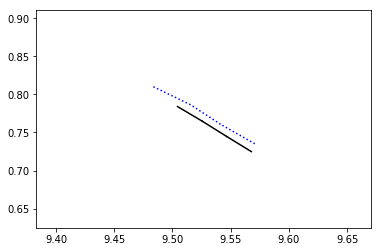

In [33]:
close_visualize(model,input_batch_padded,target_batch_padded,INPUT_LENGTH)

In [34]:
# get an overview of the prediction given the whole scene...
def visualize_batch_overview(input_batch_padded, target_batch_padded, filename = 'overview.png'):

    params, loss = model.predict([input_batch_padded,target_batch_padded])
    # visualize the trace, as well as the distributions generated by the params...
    # first clear the previous drawing...
    #     try:
    plt.gcf().clear()
    visualize_trace(input_batch,target_batch)
    #     params = params[:,INPUT_LENGTH + 1, :] # (B,5), and it should be the params immediately after the input
    #     draw_heatmap(params)
    draw_mean(params)
    plt.savefig(filename)

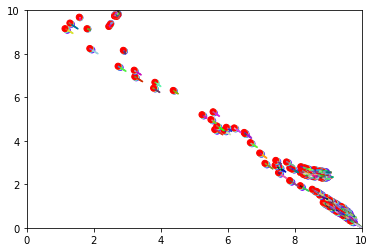

In [35]:
visualize_batch_overview(input_batch_padded, target_batch_padded)

In [ ]:
# homemade live loss callback
def live_loss_plot(log):
    